In [2]:
# 한글 폰트 관련
# 1. 나눔 폰트 설치
!apt-get -y install fonts-nanum

# 2. 런타임 재시작 없이 폰트 강제 등록
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 3. 폰트 경로 직접 지정
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fm.fontManager.addfont(font_path)
nanum_font = fm.FontProperties(fname=font_path).get_name()

# 4. matplotlib 기본 설정에 강제로 반영
mpl.rcParams['font.family'] = nanum_font
mpl.rcParams['axes.unicode_minus'] = False


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (7,565 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126380 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


import sklearn
import xgboost
from xgboost import XGBRegressor


from sklearn.model_selection import KFold

import random as rn

RANDOM_SEED = 2025
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)



from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
%cd /content/drive/MyDrive/dacon_2025_Power_usage_prediction_AI_github/2025dacon_powerU_github

In [ ]:
!git config --global user.name "SonHyesang0914"
!git config --global user.email "hyesang0914@gmail.com"

In [ ]:
train_path = "/content/drive/MyDrive/dacon_2025_Power_usage_prediction_AI/dacon_data/train.csv"
test_path = "/content/drive/MyDrive/dacon_2025_Power_usage_prediction_AI/dacon_data/test.csv"
building_info_path = "/content/drive/MyDrive/dacon_2025_Power_usage_prediction_AI/dacon_data/building_info.csv"

In [ ]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
building_info = pd.read_csv(building_info_path)

In [ ]:
train

In [ ]:
train.info()

In [ ]:
train.describe()

In [ ]:
test

In [ ]:
test.info()

In [ ]:
test.describe()

In [ ]:
building_info

In [ ]:
building_info.info()

In [ ]:
building_info.describe()

In [ ]:
#한글로 된 행 영어로 변환
train = train.rename(columns={
    '건물번호': 'building_num',
    '일시': 'date_time',
    '기온(°C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
train.drop('num_date_time', axis = 1, inplace=True)

test = test.rename(columns={
    '건물번호': 'building_num',
    '일시': 'date_time',
    '기온(°C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
test.drop('num_date_time', axis = 1, inplace=True)

building_info = building_info.rename(columns={
    '건물번호': 'building_num',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})

#한글로 된 건물 유형 영어로 변환
translation_dict = {
    '건물기타': 'Other_building',
    '공공': 'Public',
    '학교': 'University',
    '백화점': 'Department_store',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Laboratory',
    'IDC(전화국)': 'IDC',
    '호텔': 'Hotel'
}

building_info['building_type'] = building_info['building_type'].replace(translation_dict)

#태양광 기술이나 ess(pcs 포함)기술 유무 행 추가 있으면 1 없으면 0
#하는 이유? 단순 존재 여부 판단 편리 -> 시각화나 조건달 때 편리
#그리고 트리모델에서 더 잘 활용하기 위해 0과 1로 이분화
building_info['solar_power_include'] = np.where(building_info.solar_power_capacity !='-',1,0)
building_info['ess_include'] = np.where(building_info.ess_capacity !='-',1,0)

# ESS, 태양광, PCS 용량이 '-'이면 0으로 바꾸고, 나머지는 float로 변환
cols_to_convert = ['solar_power_capacity', 'ess_capacity', 'pcs_capacity']

for col in cols_to_convert:
    building_info[col] = building_info[col].replace('-', 0).astype(float)


train = pd.merge(train, building_info, on='building_num', how='left')
test = pd.merge(test, building_info, on='building_num', how='left')

In [ ]:
train['date_time'] = pd.to_datetime(train['date_time'], format='%Y%m%d %H')

# date time feature 생성
train['hour'] = train['date_time'].dt.hour
train['day'] = train['date_time'].dt.day
train['month'] = train['date_time'].dt.month
train['day_of_week'] = train['date_time'].dt.dayofweek #요일


test['date_time'] = pd.to_datetime(test['date_time'], format='%Y%m%d %H')

# date time feature 생성
test['hour'] = test['date_time'].dt.hour
test['day'] = test['date_time'].dt.day
test['month'] = test['date_time'].dt.month
test['day_of_week'] = test['date_time'].dt.dayofweek #요일

In [ ]:
train

In [ ]:
building_info["building_type"].value_counts()

In [ ]:
train["building_num"].value_counts()

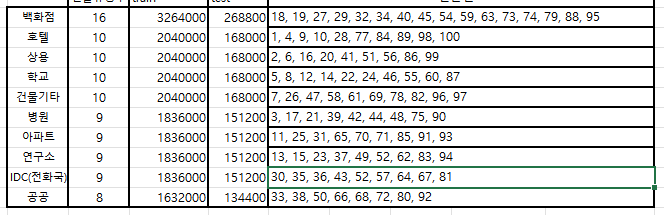


In [ ]:
from datetime import timedelta

# 시작 날짜와 종료 날짜
start = train['date_time'].min().date()
end = train['date_time'].max().date()

b_id = 1

temp = train[train['building_num'] == b_id].copy()
temp = temp.sort_values('date_time')

# 주간 단위 반복
current = start
while current + timedelta(days=7) <= end:
    s = pd.to_datetime(current)
    e = pd.to_datetime(current + timedelta(days=7))

    week_temp = temp[(temp['date_time'] >= s) & (temp['date_time'] < e)]

    plt.figure(figsize=(15, 4))
    sns.lineplot(data=week_temp, x='date_time', y='power_consumption', linewidth=0.7)
    plt.title(f"건물 {b_id} | {s.date()} ~ {(e - timedelta(days=1)).date()} 시간단위 전력사용량")
    plt.xlabel("시간")
    plt.ylabel("전력사용량 (kWh)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    current += timedelta(days=7)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

b_id = 1

temp = train[train['building_num'] == b_id].copy()

plt.figure(figsize=(20, 4))
sns.lineplot(data=temp, x='date_time', y='power_consumption', linewidth=0.5)
plt.title(f"건물 {b_id} 전체 기간 전력사용량")
plt.xlabel("시간")
plt.ylabel("전력사용량 (kWh)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
!git status
!git add 02_EDAandPreprocessing.ipynb
!git commit -m "EDA 및 전처리 노트 생성"
!git push origin main